# PyTorch: Neural Network for Option Pricing

In [1]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import tqdm
import pytorch_model_summary as pms
import matplotlib.pyplot as plt
from matplotlib import style

## Simulating Call Option Prices

In [2]:
r,T,k,sigma =[0.05,1,100,0.4]

def BS_Call_Price(t,S):
    d1 = (np.log(S/k) + (r+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
       
    price = S * norm.cdf(d1)- k * np.exp(-r*(T-t)) * norm.cdf(d2)
    return price

In [3]:
np.random.seed(1)
def gen_data(m):
    headers = ['Time', 'Stock Price', 'Option Price']
    #generate random inputs for BS_Call_Price:stock priced from 0 to 200, and a time in (0,1).
    dataset = pd.DataFrame([0,1,0] + [1,200,0]*np.random.random((m,3)),columns=headers)
    
    for i in range(0,len(dataset)):
        dataset['Option Price'].iloc[i] = BS_Call_Price(dataset['Time'].iloc[i],dataset['Stock Price'].iloc[i])   
    return(dataset)

In [4]:
dataset = gen_data(10000) 

print(dataset.head(10))

       Time  Stock Price  Option Price
0  0.417022   145.064899  4.952848e+01
1  0.302333    30.351178  1.203388e-03
2  0.186260    70.112145  3.102227e+00
3  0.538817    84.838903  4.716017e+00
4  0.204452   176.623487  8.135105e+01
5  0.670468    84.460960  3.166825e+00
6  0.140387    40.620298  8.032398e-02
7  0.968262    63.684836  1.201611e-10
8  0.876389   179.921333  8.053753e+01
9  0.039055    34.966084  3.732835e-02


Next, we need to convert our data set into tensors. More specifically, into a map-style dataset to feed into our dataloader (defined later on). For this we'll create a custom class from torch.utils.data.Dataset and overwrite the __init__(), __len__(), __getitem__() methods.

In [5]:
class OptionDataSet(torch.utils.data.Dataset):
    def __init__(self,d):
        self.X = torch.tensor(d[["Time","Stock Price"]].values, dtype = torch.float32)
        self.y = torch.unsqueeze(torch.tensor(d["Option Price"].values, dtype = torch.float32),1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.X[idx, 0:2]
        y = self.y[idx]
        return ({'X': X,'y': y})

In [6]:
tensor_dataset = OptionDataSet(dataset)
print(tensor_dataset.__len__())
print(tensor_dataset.__getitem__(range(0,10)))

10000
{'X': tensor([[4.1702e-01, 1.4506e+02],
        [3.0233e-01, 3.0351e+01],
        [1.8626e-01, 7.0112e+01],
        [5.3882e-01, 8.4839e+01],
        [2.0445e-01, 1.7662e+02],
        [6.7047e-01, 8.4461e+01],
        [1.4039e-01, 4.0620e+01],
        [9.6826e-01, 6.3685e+01],
        [8.7639e-01, 1.7992e+02],
        [3.9055e-02, 3.4966e+01]]), 'y': tensor([[4.9528e+01],
        [1.2034e-03],
        [3.1022e+00],
        [4.7160e+00],
        [8.1351e+01],
        [3.1668e+00],
        [8.0324e-02],
        [1.2016e-10],
        [8.0538e+01],
        [3.7328e-02]])}


## Splitting data into a train and test set 

In [7]:
def train_test(data, prop_test=0.2):
    train_size = round((1-prop_test)*len(data))
    test_size = round(prop_test*len(data))
    train_set, test_set = torch.utils.data.dataset.random_split(data, lengths=[train_size,test_size],)
    return train_set, test_set

In [8]:
trainset, testset = train_test(tensor_dataset)
print("trainset type: "+str(type(trainset)))
print("number of training examples: " + str(trainset.__len__()))

print("testset type: " + str(type(testset)))
print("number of testing examples: " + str(testset.__len__()))

trainset type: <class 'torch.utils.data.dataset.Subset'>
number of training examples: 8000
testset type: <class 'torch.utils.data.dataset.Subset'>
number of testing examples: 2000


## Model Definition

In [9]:
def model(n_x, num_n, n_L):
    model = nn.Sequential(
        nn.Linear(n_x, num_n)
       ,nn.ReLU()
       #,nn.BatchNorm1d(num_n)
       ,nn.Linear(num_n, num_n)
       ,nn.ReLU()
       #,nn.BatchNorm1d(num_n)
       ,nn.Linear(num_n, num_n)
       ,nn.ReLU()
       #,nn.BatchNorm1d(num_n)
       ,nn.Linear(num_n, num_n)
       ,nn.ReLU()
       #,nn.BatchNorm1d(num_n) 
       ,nn.Linear(num_n, n_L))
    return(model)

#if cuda enabled GPU available, move the networks parameters onto the device. 
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

n_x = (trainset.__getitem__(0)['X']).shape[0]
n_y = (trainset.__getitem__(0)['y']).shape[0]
net = model(n_x,64,n_y).to(device)
print("*****************************Model Summary*****************************")
print (pms.summary(net,torch.zeros(1,2).to(device)))


*****************************Model Summary*****************************
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1             [1, 64]             192             192
            ReLU-2             [1, 64]               0               0
          Linear-3             [1, 64]           4,160           4,160
            ReLU-4             [1, 64]               0               0
          Linear-5             [1, 64]           4,160           4,160
            ReLU-6             [1, 64]               0               0
          Linear-7             [1, 64]           4,160           4,160
            ReLU-8             [1, 64]               0               0
          Linear-9              [1, 1]              65              65
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
-----------------------------------------------------------------------


## Training the Model

The OptionNeuralNet Class contains a fit method, which trains the model and applies cross validation on each epoch. The class also stores the epoch history to allow for model analyses. The call backs have not yet been designed but early stopping would be a useful to prevent overfitting from training too long.

In [10]:
class OptionNeuralNet():
    def __init__(self, network, data, device, optimizer,validation_split ,call_backs):
        self.network = network
        self.data = data
        self.validation_split = validation_split
        self.optimizer = optimizer
        self.device = device
        self.call_backs=call_backs
        self.metrics = {'Epoch':[], 'loss': [], 'mae': [], 'mse': [],'val_loss':[],'val_mae':[],'val_mse':[]}
    
    def forward(self,X,y,training=False):
        if training:
            self.network.zero_grad()
        
        output = self.network(X)
        #output = torch.squeeze(output,1)
        loss = F.mse_loss(output,y)
        mae = torch.abs(output-y).sum().data.item()
        mse = ((output-y)**2).sum().data.item()
        
        if training:
            loss.backward()
            self.optimizer.step()
        
        return(self.network, loss, mae, mse)

    def fit(self,max_EPOCHS,batchSize):

        trainData, devData = train_test(self.data,self.validation_split)
        if batchSize == -1:
            train_batch = trainData.__len__()
            dev_batch = devData.__len__()
        else:
            train_batch = batchSize
            dev_batch=batchSize
        trainset = torch.utils.data.DataLoader(trainData, shuffle=False,batch_size = train_batch)
        cvset = torch.utils.data.DataLoader(devData,shuffle=False,batch_size = devData.__len__())
        
        #metrics={'Epoch':[], 'loss': [], 'mae': [], 'mse': [],'val_loss':[],'val_mae':[],'val_mse':[]}
        
        counter=0
        best=None
        
        for epoch in range(max_EPOCHS):
            
            running_mae, running_mse, epoch_loss= [0,0,0]
            
            for data in tqdm.tqdm(trainset):
                X,y = data["X"], data["y"]
                self.network, loss, mae, mse = self.forward(X.to(self.device), y.to(self.device), training=True)
                running_mae +=mae
                running_mse +=mse
                epoch_loss+=loss.item()*len(X)
            self.metrics['Epoch']+=[epoch]
            self.metrics['loss'] +=[epoch_loss/len(trainData)]
            self.metrics['mae'] +=[running_mae/len(trainData)]
            self.metrics['mse'] +=[running_mse/len(trainData)]
           
            running_mae, running_mse, epoch_loss = [0,0,0]
           
            for data in cvset:
                 X,y = data["X"], data["y"]
                 _, loss, mae, mse = self.forward(X.to(self.device), y.to(self.device))
                 epoch_loss += loss.item()*len(X)
                 running_mae += mae
                 running_mse += mse
            self.metrics['val_loss']+=[epoch_loss/len(devData)]
            self.metrics['val_mae']+= [running_mae/len(devData)]
            self.metrics['val_mse']+=[running_mse/len(devData)]

            
            #earlyStop,counter,best = earlyStopping(thisMetrics, counter,best)
            
            #if earlyStop:
                #return(network, metrics)
        
        return(self.network,self.metrics)           

Adam optimization is used to train this model. Mini batch will be used to allow for more frequent updates to model and to reduce the risk of local minima trapping since we are using MSE as our loss function. 

In [11]:
optimizer = optim.Adam(net.parameters(),lr=0.001)
Option_NN = OptionNeuralNet(net, trainset,device,optimizer,validation_split=0.2,call_backs=None)
Option_NN.fit(300,32)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 307.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 287.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 308.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 309.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 308.10it/s]


(Sequential(
   (0): Linear(in_features=2, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=64, bias=True)
   (5): ReLU()
   (6): Linear(in_features=64, out_features=64, bias=True)
   (7): ReLU()
   (8): Linear(in_features=64, out_features=1, bias=True)
 ),
 {'Epoch': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
 

In [20]:
metrics_df = pd.DataFrame(Option_NN.metrics)
pd.options.display.float_format = '{:.4f}'.format
print("training metrics")
print(metrics_df[metrics_df.Epoch>=len(metrics_df.index)-10])

training metrics
     Epoch   loss    mae    mse  val_loss  val_mae  val_mse
290    290 0.5373 0.3918 0.5373    3.1439   1.1530   3.1439
291    291 0.6971 0.4353 0.6971    0.0095   0.0605   0.0095
292    292 0.0116 0.0663 0.0116    0.0324   0.1223   0.0324
293    293 0.0263 0.0959 0.0263    0.0129   0.0779   0.0129
294    294 0.0363 0.1084 0.0363    0.0252   0.1164   0.0252
295    295 0.2948 0.2824 0.2948    0.0287   0.1267   0.0287
296    296 0.1217 0.2066 0.1217    0.0431   0.1573   0.0431
297    297 0.1755 0.2493 0.1755    0.0349   0.1287   0.0349
298    298 0.0378 0.1063 0.0378    0.1010   0.2436   0.1010
299    299 0.1559 0.2183 0.1559    0.0279   0.1187   0.0279


In [13]:
def test(net,test_data,device):
    testset = torch.utils.data.DataLoader(test_data, shuffle=False,batch_size = test_data.__len__())
    y_hat = []
    accuracy = []
    running_acc = 0
    with torch.no_grad():
        for data in testset:
            X,y = data["X"].to(device), data["y"].to(device)
            _,_,mae,_ = net.forward(X,y)
            mae = mae/test_data.__len__()
            #acc = torch.abs(output-y).sum().data/len(testset)
            
    return(mae)

In [14]:
 accuracy = test(Option_NN,testset,device)
print("test mae: " + str(accuracy))

test mae: 0.11844563293457032


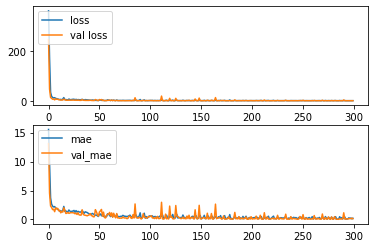

In [22]:
fig = plt.figure()
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex =ax1)

ax1.plot(metrics_df.Epoch, metrics_df.loss,label='loss')
ax1.plot(metrics_df.Epoch,metrics_df.val_loss,label = 'val loss')
ax1.legend(loc=2)
ax2.plot(metrics_df.Epoch, metrics_df.mae,label='mae')
ax2.plot(metrics_df.Epoch, metrics_df.val_mae,label='val_mae')
ax2.legend(loc=2)

In [16]:
def visualize_trainedModel(net,device):
    
    B = []
    index = []
    for i in range(1,200):
        index.append(i)
        B.append(BS_Call_Price(0,i))
    S = torch.tensor(np.reshape(np.linspace(1,199,num=199),(199,1)), dtype = torch.float32).to(device)
    t = torch.tensor(np.zeros(shape=(199,1)), dtype = torch.float32).to(device)
    X_test = torch.cat([t,S], dim=1)
    X_test = X_test.to(device)
    y_test = torch.zeros(X_test.shape)
    y_test = y_test.to(device)
    DD=[]
    with torch.no_grad():
        DD = net(X_test)
        
    plt.plot(index, B, color="blue", label='Analytical', linewidth=4)
    plt.plot(index, DD.to("cpu"), color="red", label='NeuralNet', linestyle='dashed', linewidth=3)
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.xlim([-5, 215]) 
    plt.ylim([-5, 115]) 
    plt.legend()
    plt.show()

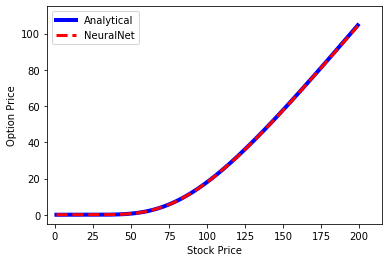

In [17]:
visualize_trainedModel(Option_NN.network,device)